# Engenius '20 - EDA

## Summary

The Main goal is to predict the quantities sold of a set of products within a 4 months time frame.

# Table Of Contents

# Exploratory Data Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

product_sheets = ['PRODUCT_A', 'PRODUCT_B', 'PRODUCT_C', 'PRODUCT_V', 'PRODUCT_X']
data = {}

for s in product_sheets:
    data[s] = pd.read_excel('datasets/Data2017-2019.xls', s)
    


In [3]:
# merge data frames for all 5 products vertically
df_all5 = data[product_sheets[0]]
for i,s in enumerate(product_sheets):
    if i != 0:
        df_all5 = df_all5.append(data[s], ignore_index=True)


In [4]:
df_all5.shape

(58032, 5)

In [8]:
df_all5.Product.value_counts()

PRODUCT_A    17371
PRODUCT_B    17962
PRODUCT_C    17980
PRODUCT_V     1799
PRODUCT_X     2920
Name: Product, dtype: int64

### Null Valued Features
- ratio of null values
  No null values as seen below

In [5]:
(df_all5.isnull().sum() / df_all5.shape[0])

Year        0.0
Period      0.0
Product     0.0
Province    0.0
Quantity    0.0
dtype: float64

* ratio of transactions (sales) with negative quantities
  probably product return

In [6]:
(df_all5[df_all5.Quantity < 0].shape[0] / df_all5.shape[0])

0.0016197959746346844

In [22]:
data_sorted = df_all5.sort_values(by=['Period', 'Province', 'Product']).reset_index(drop=True)
data_sorted.head(5)

,Year,Period,Product,Province,Quantity
0,2017,201701,PRODUCT_A,ADANA,11
1,2017,201701,PRODUCT_A,ADANA,25
2,2017,201701,PRODUCT_A,ADANA,54
3,2017,201701,PRODUCT_A,ADANA,17
4,2017,201701,PRODUCT_A,ADANA,30


In [8]:
data_sorted = df_all5.sort_values(by=['Period', 'Province', 'Product']).reset_index()
data_sorted.head(5)

,index,Year,Period,Product,Province,Quantity
0,4,2017,201701,PRODUCT_A,ADANA,11
1,5,2017,201701,PRODUCT_A,ADANA,25
2,7,2017,201701,PRODUCT_A,ADANA,54
3,8,2017,201701,PRODUCT_A,ADANA,17
4,9,2017,201701,PRODUCT_A,ADANA,30


In [ ]:
#aggragate products sold

In [26]:
data_aggragated = data_sorted.groupby(['Period', 'Province', 'Product'])['Quantity'].sum().reset_index()
data_aggragated.head(10)

,Period,Province,Product,Quantity
0,201701,ADANA,PRODUCT_A,346
1,201701,ADANA,PRODUCT_B,4838
2,201701,ADANA,PRODUCT_C,1004
3,201701,ADANA,PRODUCT_V,20
4,201701,ADANA,PRODUCT_X,910
5,201701,ADIYAMAN,PRODUCT_A,36
6,201701,ADIYAMAN,PRODUCT_B,45
7,201701,ADIYAMAN,PRODUCT_C,206
8,201701,ADIYAMAN,PRODUCT_X,44
9,201701,AFYON,PRODUCT_A,66


In [25]:
data_aggragated.shape

(13523, 4)

### Distribution of Products Sold

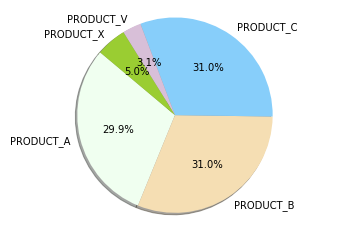

In [19]:
labels = product_sheets
df_all5.Product.value_counts().sort_index().tolist()
sizes = df_all5.Product.value_counts().sort_index().tolist()
colors = ['honeydew', 'wheat', 'lightskyblue', 'thistle', 'yellowgreen']
#explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()
